# NNET

This is my Jupyter notebook with notes / implementation of a shallow neural network in Julia. All materials are based on deeplearning.ai's Deep Learning Specialization. I refer to specific videos and other materials where applicable. **The notebook is not yet finished**

I created this notebook to review some of the concepts I learned in the first three courses of the deep learning specialization. Its purpose is primarily for me to process the information and produce the implementation from my own understanding rather than simply copying it from another place. As a result, you may find that the implementation notes are somewhat long-winded or tangential.

If you find a mistake or think this code can be improved, it would be great if you could fork the repository and make a pull request. You could also leave a comment in the issues section.

### This notebook contains

- Loading & pre-processing the MNIST dataset
- forward and backward propagation using a 2-layer neural network
- ReLU / sigmoid / 'safe' softmax activation functions
- Inverted dropout implementation
- Weight initialization 
- RMSprop
- Learning rate decay
- mini-batch gradient descent

### References

- I refer to the deep learning specialization course materials where applicable
- I translated some of the numpy code from Jonathan Weisberg's "Building a Neural Network from Scratch" [part I](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/) and [part II](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%202/) to Julia

## Loading the MNIST dataset

The MNIST dataset contains $60.000$ images of digits $1-10$. We use the MLDatasets module to retrieve and load the data. Normally, we would [normalize](https://www.coursera.org/learn/deep-neural-network/lecture/lXv6U/normalizing-inputs) the input data such that it has mean $0$ and standard deviation $1$ (also known as a standard normal distribution). However, this has already been done for this version of the MNIST dataset.

In [3]:
using MLDatasets

# Train & test data
train_x, train_y = MNIST.traindata();
test_x, test_y = MNIST.testdata();

# Note that the data have been normalized already
# See: https://juliaml.github.io/MLDatasets.jl/latest/datasets/MNIST/

The shapes of the data are as follows

In [4]:
## Get shapes
println(size(train_x))
println(size(train_y))
trainsize = size(train_x)[3];

(28, 28, 60000)
(60000,)


I find it easier to think about the data if the examples are in the row dimension. We will reshape the data such that $X$ is a tensor of shape $(60.000, 784)$. 

In [5]:
# Reshape x
train_x = transpose(reshape(train_x, 28 * 28, size(train_x)[3]));
test_x = transpose(reshape(test_x, 28 * 28, size(test_x)[3]));

# Reshape Y
train_y = reshape(train_y, size(train_y)[1], 1);
test_y = reshape(test_y, size(test_y)[1], 1);

In [6]:
size(train_x)

(60000, 784)

$Y$ has $10$ unique labels ranging from $0-9$. However, this is actually a recoding of the data. MORE

In [7]:
size(train_y)

(60000, 1)

In [8]:
unique(train_y)

10-element Array{Int64,1}:
 5
 0
 4
 1
 9
 2
 3
 6
 7
 8

### The data until now

- $X$ is a tensor with dimension $(60.000, 784)$
- $Y$ is a tensor with dimension $(60.000, 1)$

<img src="img/XandY2.png" width = "500px">

### Creating a one-hot encoding for $Y$

In order to train the neural network, we need to one-hot-encode <link> the outcome variable $Y$.

The trick to doing this is as follows:

- Create a $k \times k$ identity matrix. In our case, we have $k=10$, so:

$$
I = 
\begin{bmatrix}
1 & 0 & \dots & 0 \\
0 & 1 & \dots & 0 \\
\vdots & \vdots & \ddots & 0 \\
0 & 0 & \dots & 1
\end{bmatrix}
$$

- For each example in $Y$, *index the column of the value of the label*. For example, if the the label equals '5', we index the $5^{th}$ column, which has a $1$ on the $5^{th}$ element and zeroes elsewhere

$$
\begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
1 \\
0 \\
0 \\
0 \\
0 \\
0 
\end{bmatrix}
$$

- Because we do this $n$ times (the number of training examples), we will end up with a tensor of size $(10, 60.000)$

$$
\begin{bmatrix}
0 & 0 & 0 & \dots & 1 \\
1 & 1 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 1 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0
\end{bmatrix}
$$

- Again, I like to think in terms of (examples, dimensions) so we will transpose the one-hot-encoded matrix such that it has the dimensions $(60.000, 10)$

<img src="img/y_one_hot.png" width = "300px">

In [9]:
# One-hot encoding for y
# We need a shape for outcome variable of size [num_labels, num_examples]

# Number of distinct classes
k = length(unique(train_y));
# Number of training examples
n = size(train_y)[1];

In [10]:
using LinearAlgebra

function one_hot_encode(y_labels)
    
    #=
    From multiclass labels to one-hot encoding
    
    :param y_labels: column vector of shape (number of examples, 1) containing k > 2 classes
    
    :return: one-hot encoded labels
    =#
    
    # Number of distinct classes
    k = length(unique(y_labels));
    # Number of rows
    n = size(y_labels)[1];
    
    # 1. Create k x k identity matrix 

    # Arrange the identity matrix such that, for each class, we get a one-hot encoded vector.
    # This means that the rows are of length k (the number of distinct classes)
    # The columns are of length n (the number of examples).
    y_ohe = Matrix{Float64}(I, k, k)

    # 2. Organize such that we get a k x m matrix. We do this by letting the label index
    #     the column value. Since we have m labels, we index the columns m times.
    #     So for m = 1.000 where m_1000 = 3, we index the kth column [0,0,1,0,...,k]
    
    # We have to add +1 to the classes (because Julia indexes from 1)
    # Unlike e.g. numpy we need to explicitly call 'broadcast' to match shapes between
    # two elements that we're adding
    y_ohe = y_ohe[:, broadcast(+, y_labels, 1)][:,:];
    
    # Return
    return(y_ohe)
    
    end;

# One-hot encoding
y_train_ohe = transpose(one_hot_encode(train_y));
y_test_ohe = transpose(one_hot_encode(test_y));

println(size(y_train_ohe))
println(size(y_test_ohe))

(60000, 10)
(10000, 10)


just to make sure that the one-hot encoding was done properly, we can randomly sample a number of values and check if the one-hot encoded examples line up with the original labels.

In [11]:
using Random

function sanity(y_ohe, train_y; n_sample = 5)
    
    #=
    Ensure that one-hot encoded labels are encoded properly by transforming them back into
     labels.
    
    :param y_ohe: one-hot encoded training labels
    :param train_y: array of size (examples, 1) containing the labels
    :param n_sample: number of examples to sample randomly
    
    :return: This function does not return a value
    =#
    
    # Shapes
    n, k = size(y_ohe)
    
    # Pick a random example
    ind_shuffled = shuffle(1:n)
    
    # Subset
    ind = ind_shuffled[1:n_sample]
    
    # For each, print OHE + convert back to class
    for i in ind
        
        # Find position of 1
        pos = findall(x -> x==1, y_ohe[i, :])
        
        # Subtract 1
        pos = pos[1] - 1
        
        # Print
        println("Example ", i, ":\n", 
                "\t[OHE position: ", pos, "] ==> [label: ", train_y[i,1], "]")
        
    end
    
end;

In [12]:
sanity(y_train_ohe, train_y)

Example 50075:
	[OHE position: 8] ==> [label: 8]
Example 35275:
	[OHE position: 5] ==> [label: 5]
Example 39240:
	[OHE position: 4] ==> [label: 4]
Example 41723:
	[OHE position: 4] ==> [label: 4]
Example 16998:
	[OHE position: 0] ==> [label: 0]


### NNet functions

Plan: build a neural net with one hidden layer and $n_h$ hidden units

TODO:

- Notation
- Matrix calculus (see https://atmos.washington.edu/~dennis/MatrixCalculus.pdf)
- Images of the neural network structure
- Backprop computation graph image + derivatives
    * Also when using Tanh
- References
    * Chollet Keras
    * Coursera course
- 'safe' softmax function
- dropout

### Cross validation

In [13]:
function cross_validation(X, Y, split_prop = 0.05)
    
    #=
    Create train/test split
    
    :param X: Input data X
    :param Y: output data Y
    :param split_prop: percentage of data to use as validation set
    
    :return: dictionary with train & validation data
    :seealso: https://www.coursera.org/learn/deep-neural-network/lecture/cxG1s/train-dev-test-sets
    =#
    
    # Number of training examples
    trainsize = size(X)[1]
    
    # Number of validation examples
    ndev = Integer(floor(trainsize * split_prop))
    
    # Shuffle indices
    ind = shuffle(1:trainsize);
    # Rearrange train x and y
    X = X[ind, :];
    Y = Y[ind, :];

    # Validation split
    dev_x = X[1:ndev, :];
    dev_y = Y[1:ndev, :];

    # Remove from train
    train_x = X[ndev+1:end, :];
    train_y = Y[ndev+1:end, :];
    
    # To dict
    split = Dict(
        "X_train" => train_x,
        "Y_train" => train_y,
        "X_dev" => dev_x,
        "Y_dev" => dev_y
    )
    
    # Return
    return(split)
    
    end;

### Weight initialization

$$
W^{[l]} = (n^{[l]},n^{[l-1]}) 
$$

In [420]:
function initialize_parameters(n_x, n_h1, n_h2, n_y)
    
    #=
    Initialize the weight matrices and bias vectors
    
    :param n_x: number of observations in the input data
    :param n_h1: number of hidden units in the first layer
    :param n_h2: number of hidden units in the second layer
    :param n_y: number of labels in the output data
    
    :return:
       - parameters: dict containing weights W and bias vectors b for each layer
       - cache:      dict containing the adjusted weights used for RMSprop (see below)
    
    :seealso: 
       - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/XtFPI/random-initialization
       - https://www.coursera.org/learn/deep-neural-network/lecture/C9iQO/vanishing-exploding-gradients
       - https://www.coursera.org/learn/deep-neural-network/lecture/RwqYe/weight-initialization-for-deep-networks
       - https://stats.stackexchange.com/questions/47590/what-are-good-initial-weights-in-a-neural-network
       - https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94
    =#
    
    # For sigmoid / tanh / softmax --> Xavier weight initialization --> 1 / sqrt(units in previous layer)
    # For ReLU weight initialization --> 2 / sqrt(units in previous layer)
    
    W1 = randn(n_h1, n_x) .* sqrt(2 / n_x) # 
    b1 = zeros(n_h1, 1)
    W2 = randn(n_h2, n_h1) .* sqrt(2 / n_h1) 
    b2 = zeros(n_h2, 1)
    W3 = randn(n_y, n_h2) .* sqrt(1 / n_h2)
    b3 = zeros(n_y, 1)
    
    # Exponentially weighted values initialization
    vdW1 = zeros(n_h1, n_x)
    vdb1 = zeros(n_h1, 1)
    vdW2 = zeros(n_h2, n_h1)
    vdb2 = zeros(n_h2, 1)
    vdW3 = zeros(n_y, n_h2)
    vdb3 = zeros(n_y, 1)
    
    # Create parameters dict
    parameters = Dict(
        "W1" => W1,
        "b1" => b1,
        "W2" => W2,
        "b2" => b2,
        "W3" => W3,
        "b3" => b3
    )
    
    # Create cache dict
    cache = Dict(
        "vdW1" => vdW1,
        "vdb1" => vdb1,
        "vdW2" => vdW2,
        "vdb2" => vdb2,
        "vdW3" => vdW3,
        "vdb3" => vdb3
    )
    
    # Return
    return((parameters, cache))
    
    end;

### Mini-batch gradient descent

An algorithm for splitting the data into batches is given below. Here:

- $n$ is the number of training examples
- $k$ is the batch size
- $j$ is the number of total batches that can be created **using the batch size $k$**

That is, $j$ is the integer part of the division of $\frac{n}{k}$.

<img src="img/minibatch.png" width = "500px">

This toy example is given as an algorithm below

In [421]:
# Number of examples
n = 101;
# Batch size
k = 10;
# Number of batches of size k (discounting any remainders)
j = floor(n/k);

# For each minibatch
for i = 1:j
    
    # Start at 1 if minibatch is 1
    if i == 1
        index_begin = 1
    else
        # Else start at the end of the previous minibatch plus one
        index_begin = Integer(((i - 1) * k) + 1)
        end;
    
    # End 
    index_end = Integer((i * k))
    
    println("Minibatch ", Integer(i), "\n\t[Begin ", index_begin, "] ==> [end ", index_end, "]")
    
    end;

# If there is a remainder
if n - (j * k) > 0
    
    index_begin = Integer((j * k) + 1)
    index_end = n
    
    println("Minibatch ", Integer(j+1), "\n\t[Begin ", index_begin, "] ==> [end ", index_end, "]")
    
    end;

Minibatch 1
	[Begin 1] ==> [end 10]
Minibatch 2
	[Begin 11] ==> [end 20]
Minibatch 3
	[Begin 21] ==> [end 30]
Minibatch 4
	[Begin 31] ==> [end 40]
Minibatch 5
	[Begin 41] ==> [end 50]
Minibatch 6
	[Begin 51] ==> [end 60]
Minibatch 7
	[Begin 61] ==> [end 70]
Minibatch 8
	[Begin 71] ==> [end 80]
Minibatch 9
	[Begin 81] ==> [end 90]
Minibatch 10
	[Begin 91] ==> [end 100]
Minibatch 11
	[Begin 101] ==> [end 101]


The code below implements mini-batches for real data

In [422]:
function create_batches(X, Y, batch_size = 128)
    
    #=
    Creates b batches of size batch_size
    
    :param X:          input data X
    :param Y:          output data Y
    :param batch_size: size of each batch
    
    :return: list containing m batches of length batch_size and possibly 1 batch of size batch_size_remainder < batch_size
    :seealso: 
      - https://www.coursera.org/learn/deep-neural-network/lecture/qcogH/mini-batch-gradient-descent
      - https://www.coursera.org/learn/deep-neural-network/lecture/lBXu8/understanding-mini-batch-gradient-descent
    =#
    
    # Shuffle training examples randomly
    n = size(X)[1]
    ind = shuffle(1:n)
    
    # Rearrange data in X and Y
    X = X[ind, :]
    Y = Y[ind, :]
    
    # List to store minibatches
    mbatches = []
    
    # Number of complete training examples. 
    #  This means: n / 128 leaves a remainder (most likely)
    #  Therefore, there will be (b - 1) batches with size batch_size
    #  and 1 batch with size last_batch_size < batch_size
    b_first = Integer(floor(n / batch_size))
    
    # First, loop through the (b_first - 1) examples
    #  We need to loop through b_first - 1 because we construct 
    #    @ index_begin => i * batch_size (e.g. 9 * 128 = 1152)
    #    @ index_end => (i + 1) * batch_size (e.g. 10 * 128 = 1280)
    #  index_end needs (i + 1). If i == k where k is the last possible index, we cannot subset index_end
    #  because it would require (k + 1) indices.
    for i = 1:b_first
        
        # Beginning and end indices
        if i == 1
            index_begin = 1
        else
            index_begin = Integer(((i - 1) * batch_size) + 1)
            end;
        
        index_end = Integer(i * (batch_size))
        
        X_current_batch = X[index_begin:index_end, :]
        Y_current_batch = Y[index_begin:index_end, :]

        # Add to array of minibatches
        push!(mbatches, [X_current_batch, Y_current_batch])
        
        end;
    
    # Then, if necessary, make a batch for the remainder
    b_rem = n - (b_first * batch_size)
    if b_rem != 0
        
        # Subset X & Y
        index_begin = Integer(((b_first) * batch_size) + 1) # i+1 is from the for-loop above (i.e. the last 'full' minibatch of size batch_size)
        index_end = n 
        
        X_current_batch = X[index_begin:index_end, :]
        Y_current_batch = Y[index_begin:index_end, :]
        
        # Append
        push!(mbatches, [X_current_batch, Y_current_batch])
        
        end;
    
    # Return mini batches
    return(mbatches)
    
    end;

### Activation functions and Loss function

In [423]:
function softmax(z)
    
    #=
    Softmax function
    
    :param z: result of the linear transformation of the final layer
    :return: activations for z
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4dDC1/activation-functions
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/OASKH/why-do-you-need-non-linear-activation-functions
      - https://www.coursera.org/learn/deep-neural-network/lecture/HRy7y/softmax-regression
      - https://www.coursera.org/learn/deep-neural-network/lecture/LCsCH/training-a-softmax-classifier
    =#
    
    # Subtract the max of z to avoid exp(z) getting too large
    z = z .- maximum(z)
    
    # Softmax & return
    return(exp.(z) ./ sum(exp.(z),dims=1))
    
    end;

function sigmoid(z)
    
    #=
    Sigmoid function
    
    :param z: result of the linear transformation for layer l
    :return: activations for z
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4dDC1/activation-functions
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/OASKH/why-do-you-need-non-linear-activation-functions
    =#
    
    1 ./ (1 .+ exp.(-z))
    
    end;

function ReLU(z)
    
    #=
    ReLU implementation
    
    :param z: result of the linear transformation for layer l
    :return: activations for z
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4dDC1/activation-functions
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/OASKH/why-do-you-need-non-linear-activation-functions
    =#
    
    ((z .> 0) * 1) .* z
    
    end;

function crossentropy_cost(y, yhat)
    
    #=
    Crossentropy cost function for m classes
    
    :param y: actual (one-hot encoded) values for y
    :param yhat: predicted (one-hot encoded) values for yhat
    
    :return: loss value
    
    :seealso: https://www.coursera.org/learn/neural-networks-deep-learning/lecture/yWaRd/logistic-regression-cost-function
    =#
    
    loss = sum(transpose(y) .* log.(yhat))
    n = size(y)[1]
    
    return(-(1/n) * loss)
    
    end;

### Dropout regularization

In [424]:
# Vectorized dropout
function dropout(X, drop_chance = 0.8)
    
    #=
    Dropout implementation. Randomly sets the weights of some hidden units to 0
    
    :param X: input data
    :param drop_chance: probability of keeping a hidden unit
    
    :return: dropout matrix containing 1 for each unit that should be kept and 0 for each unit that should be 
              dropped. also returns X in which some units are dropped and the remaining units are scaled by 
              drop_chance.
    
    :seealso:
      - https://www.coursera.org/learn/deep-neural-network/lecture/eM33A/dropout-regularization
      - https://www.coursera.org/learn/deep-neural-network/lecture/YaGbR/understanding-dropout
    =#
    
    n = size(X)[1]
    k = size(X)[2]
    
    # Uniformly distributed probabilities
    a = rand(n, k)
    
    # Evaluate against dropout probability
    #  run the mask and turn boolean into integer
    D = (a .< drop_chance) * 1
    
    # Element-wise multiplication
    X = D .* X

    # Scale
    X = X ./ drop_chance
    
    # Return
    return((D, X))
    
    end;

### Forward propagation

<img src="img/dims.png" width = "300px">

<img src="img/forwardprop.png" width = "800px">

In [425]:
function forward_prop(parameters, cache, X, drop_chance = 0.2)
    
    #=
    Forward propagation
    
    :param parameters:  dict containing weights and bias vectors for each layer
    :param cache:       dict containing computations, dropout vectors and exponentially weighted gradients
    :param X:           input data
    :param drop_chance: probability of keeping a hidden unit
    
    :return: updated cache with dropout vectors and the computations for each forward pass for the current 
              minibatch
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4WdOY/computation-graph
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/tyAGh/computing-a-neural-networks-output
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/MijzH/forward-propagation-in-a-deep-network
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/Rz47X/getting-your-matrix-dimensions-right
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/znwiG/forward-and-backward-propagation
    =#
    
    # Retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    ## First layer
    
    # Forward propagation
    Z1 = broadcast(+, W1 * transpose(X), b1, 1)
    A1 = ReLU(Z1) 
    
    # Apply dropout
    D1, A1 = dropout(A1, drop_chance)
    
    ## Second layer
    
    # Forward
    Z2 = broadcast(+, W2 * A1, b2, 1)
    A2 = ReLU(Z2) 
    
    # Apply dropout
    D2, A2 = dropout(A2, drop_chance)
    
    ## Output layer
    
    # Forward
    Z3 = broadcast(+, W3 * A2, b3, 1)
    A3 = softmax(Z3)
    
    # Return values 
    cache["Z1"] = Z1
    cache["A1"] = A1
    cache["Z2"] = Z2
    cache["A2"] = A2
    cache["Z3"] = Z3
    cache["A3"] = A3
    cache["D1"] = D1
    cache["D2"] = D2
    
    # Return
    return(cache)   
    
    end;

### Backpropagation

In [426]:
# Derivatives of activation functions
function dSigmoid(z)
    
    #=
    Derivative of the sigmoid function
    
    :param z: result of the linear transformation computed during forward propagation. Generally:
                   Z = W_lA_{l-1} + b_l
    :return: derivative of the activation function
    
    :seealso: 
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/qcG1j/derivatives-of-activation-functions
      - https://deepnotes.io/softmax-crossentropy
      - https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
    =#
    
    sigmoid(z) .* (1 .- sigmoid(z))
    
    end;

function dReLU(z)
    
    #=
    Derivative of ReLU function
    
    :param z: result of the linear transformation computed during forward propagation. Generally:
                   Z = W_lA_{l-1} + b_l
    :return: derivative of the activation function
    
    :seealso: https://www.coursera.org/learn/neural-networks-deep-learning/lecture/qcG1j/derivatives-of-activation-functions
    =#
    
    (z .> 0) * 1
    
    end;

function dTanh(z)
    
    #=
    Derivative of tanh function
    
    :param z: result of the linear transformation computed during forward propagation. Generally:
                   Z = W_lA_{l-1} + b_l
    :return: derivative of the activation function
    
    :seealso: https://www.coursera.org/learn/neural-networks-deep-learning/lecture/qcG1j/derivatives-of-activation-functions
    =# 
    
    1 .- (tanh.(z) .* tanh.(z))
    
    end;

In [427]:
function backward_prop(cache, parameters, X, Y, drop_chance)
    
    #=
    Backward propagation
    
    :param parameters:  dict containing weights and bias vectors for each layer
    :param cache:       dict containing computations, dropout vectors and exponentially weighted gradients
    :param X:           input data
    :param drop_chance: probability of keeping a hidden unit
    
    :return: updated cache with new gradients for the current minibatch
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/0ULGt/derivatives
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/oEcPT/more-derivative-examples
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4WdOY/computation-graph
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/0VSHe/derivatives-with-a-computation-graph
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/6dDj7/backpropagation-intuition-optional
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/znwiG/forward-and-backward-propagation
      Docs about dims argument for sum()
      - https://docs.julialang.org/en/v0.6.1/stdlib/collections/#Base.sum
    =#
    
    # Dims
    n = size(Y)[1]
    
    # Unroll cache
    A3 = cache["A3"]
    Z3 = cache["Z3"]
    A2 = cache["A2"]
    Z2 = cache["Z2"]
    A1 = cache["A1"]
    Z1 = cache["Z1"]
    D1 = cache["D1"]
    D2 = cache["D2"]
    
    # Retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    ## Output layer
    dZ3 = A3 .- transpose(Y)                # Softmax derivative ==> d/dZ softmax(Z3)
    dW3 = (1/n) .* (dZ3 * transpose(A2))    # W3 derivative      ==> d/W3 W3A3 + b3
    db3 = (1/n) .* sum(dZ3, dims = 2)       # b3 derivative      ==> d/b3 W3A3 + b3
    
    ## Second layer
    dA2 = transpose(W3) * dZ3               # Derivative of the activation of 2nd layer (A2 = ReLU(W2A2 + b2))
                                            
    # Apply dropout
    dA2 = D2 .* dA2                         # Apply dropout to the derivatives
    dA2 = dA2 ./ drop_chance                # scale the activations
    
    # Derivatives of weights
    dZ2 = dA2 .* dReLU(Z2)                  # etc . . . 
    dW2 = (1/n) .* (dZ2 * transpose(A1))
    db2 = (1/n) .* sum(dZ2, dims=2)
    
    ## First layer
    dA1 = transpose(W2) * dZ2
    
    # Apply dropout
    dA1 = D1 .* dA1
    dA1 = dA1 ./ drop_chance
    
    # Derivatives of weights
    dZ1 = dA1 .* dReLU(Z1)
    dW1 = (1/n) .* (dZ1 * X)
    db1 = (1/n) .* sum(dZ1, dims=2)
    
    # Add to cache and return
    cache["dW1"] = dW1
    cache["db1"] = db1
    cache["dW2"] = dW2
    cache["db2"] = db2
    cache["dW3"] = dW3
    cache["db3"] = db3
    
    # Return cache
    return(cache)
    
    end;

### Updating weights: RMSprop

In [428]:
function RMSprop(parameters, cache, alpha, beta = 0.9, epsilon = 1e-8)
    
    #=
    Update parameters and implement exponentially weighted averages
    
    :param parameters:  dict containing weights and bias vectors for each layer
    :param cache:       dict containing computations, dropout vectors and exponentially weighted gradients
    :param alpha:       learning rate
    :param beta:        exponential weighting value. Usually set at 0.9 <MORE>
    :param epsilon:     small value to prevent divide by zero
    
    :return: updates weights in cache for current minibatch
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/A0tBd/gradient-descent
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/udiAq/gradient-descent-on-m-examples
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/Wh8NI/gradient-descent-for-neural-networks
      - https://www.coursera.org/learn/deep-neural-network/lecture/duStO/exponentially-weighted-averages
      - https://www.coursera.org/learn/deep-neural-network/lecture/Ud7t0/understanding-exponentially-weighted-averages
      - https://www.coursera.org/learn/deep-neural-network/lecture/XjuhD/bias-correction-in-exponentially-weighted-averages
      - https://www.coursera.org/learn/deep-neural-network/lecture/y0m1f/gradient-descent-with-momentum
      - https://www.coursera.org/learn/deep-neural-network/lecture/BhJlm/rmsprop
    =#
    
    # Unroll cache
    dW1 = cache["dW1"]
    db1 = cache["db1"]
    dW2 = cache["dW2"]
    db2 = cache["db2"]
    dW3 = cache["dW3"]
    db3 = cache["db3"]
    
    vdW1 = cache["vdW1"]
    vdb1 = cache["vdb1"]
    vdW2 = cache["vdW2"]
    vdb2 = cache["vdb2"]
    vdW3 = cache["vdW3"]
    vdb3 = cache["vdb3"]
    
    # Retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # Create new vdW and vdb
    #  Notice that we square the gradients element-wise
    vdW1 = beta .* vdW1 .+ (1 - beta) .* dW1.^2
    vdb1 = beta .* vdb1 .+ (1 - beta) .* db1.^2
    vdW2 = beta .* vdW2 .+ (1 - beta) .* dW2.^2
    vdb2 = beta .* vdb2 .+ (1 - beta) .* db2.^2
    vdW3 = beta .* vdW3 .+ (1 - beta) .* dW3.^2
    vdb3 = beta .* vdb3 .+ (1 - beta) .* db3.^2
    
    # Update parameters
    W1 = W1 .- (alpha .* (dW1 ./ (sqrt.(vdW1) .+ epsilon)))
    b1 = b1 .- (alpha .* (db1 ./ (sqrt.(vdb1) .+ epsilon)))
    W2 = W2 .- (alpha .* (dW2 ./ (sqrt.(vdW2) .+ epsilon)))
    b2 = b2 .- (alpha .* (db2 ./ (sqrt.(vdb2) .+ epsilon)))
    W3 = W3 .- (alpha .* (dW3 ./ (sqrt.(vdW3) .+ epsilon)))
    b3 = b3 .- (alpha .* (db3 ./ (sqrt.(vdb3) .+ epsilon)))
    
    # Store parameters
    parameters["W1"] = W1
    parameters["b1"] = b1
    parameters["W2"] = W2
    parameters["b2"] = b2
    parameters["W3"] = W3
    parameters["b3"] = b3
    
    # Store exponentially weighted gradients
    cache["vdW1"] = vdW1
    cache["vdb1"] = vdb1
    cache["vdW2"] = vdW2
    cache["vdb2"] = vdb2
    cache["vdW3"] = vdW3
    cache["vdb3"] = vdb3
    
    # Return parameters and cache
    return((parameters, cache))
    
    end;

### Learning rate decay

In [429]:
function learning_rate_decay(alpha, epoch, decay = 1)
    
    #= 
    Decays the value of alpha (learning rate) as number of epochs increases
    
    :param alpha: learning rate 
    :param epoch: current epoch number
    :param decay: decay value
    
    :return: updated learning rate
    
    :seealso: https://www.coursera.org/learn/deep-neural-network/lecture/hjgIA/learning-rate-decay
    =#
    
    alpha_new = 1 / (1 + decay * epoch) * alpha
    
    # Return
    return(alpha_new)
    
    end;


### Evaluation functions

In [817]:
function predict(X, parameters)
    
    #=
    Predict Y given X and the parameters
    
    :param X:          input data
    :param parameters: parameters for each layer
    
    :return: predicted values given X and parameters
    =#
    
    # Unroll parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # Forward prop
    Z1 = broadcast(+, W1 * transpose(X), b1, 1)
    A1 = ReLU(Z1) 
    # Second layer
    Z2 = broadcast(+, W2 * A1, b2, 1)
    A2 = ReLU(Z2) 
    # Output layer
    Z3 = broadcast(+, W3 * A2, b3, 1)
    A3 = softmax(Z3)
    
    # Return
    return(A3)
    
    end;

function accuracy(Y, Yhat)
    
    #=
    Calculates accuracy
    
    :param Y:    actual outcome values (as one-hot encoded) 
    :param Yhat: predicted outcome values (as one-hot encoded)
    
    :return: accuracy of the predictions as a float between 0 and 1
    =# 
    
    # Predictions --> labels
    vals, inds = findmax(Yhat, dims = 1);
    Yhat_labels = map(x -> x[1] - 1, inds)

    # Y ohe --> labels
    vals, inds = findmax(transpose(Y), dims=1)
    Y_labels = map(x -> x[1] - 1, inds)
    
    # Accuracy
    return(sum(Y_labels .== Yhat_labels) / length(Y_labels))
    
    end;

function evaluate_model(X, Y, parameters; return_accuracy = false)
    
    #= 
    Evaluate the model on the development & train sets
    
    :param X:               input data 
    :param Y:               output data
    :param parameters:      dict containing parameters for each layer
    :param return_accuracy: boolean. If true, returns loss and accuracy. If false, only returns loss
    
    :return: either loss and accuracy or only loss value
    =#
    
    # Predict
    Yhat = predict(X, parameters)
    
    # Loss
    loss = crossentropy_cost(Y, Yhat)
    
    # Accuracy
    if return_accuracy
        acc = accuracy(Y, Yhat)
        return((loss, acc))
        
        end;
    
    # Return
    return(loss)
    
    end;

using Plots

function plot_history(history)
    
    #=
    Plot loss across epochs
    
    :param history: nn history returned by nnet function
    
    :return: this function plots the history but does not return a value 
    
    :seealso: https://docs.juliaplots.org/latest/tutorial/#plot-recipes-and-recipe-libraries
    =#
    
    # Retrieve data
    epoch = [x[1] for x in history]
    train_loss = [x[2] for x in history]
    dev_loss = [x[3] for x in history]
    # Train and dev loss in one array (2 columns)
    loss = hcat(train_loss, dev_loss);
    
    # Plot epochs versus loss
    plot(epoch, loss, seriestype=:line, xlabel = "epoch", ylabel = "cost", lab = ["Train" "Dev"],
         lw = 2)
    
    end;

### Pulling it all together: the nnet() function

In [818]:
function nnet(X, Y; n_h1 = 16, n_h2 = 8, validation_split = 0.1, alpha = 0.05, beta=0.9,
              epsilon=10e-8, epochs = 10, batch_size=128, lr_decay=1, dropout_prop=0.3)
    
    #= 
    Implements a two-layer neural network
    
    :param X:                   input data
    :param Y:                   actual outcome values (as one-hot encoded) 
    :param n_h1:                hidden units for layer 1
    :param n_h2:                hidden units for layer 2
    :param validation_split:    decimal indicating what percentage of the data should be reserved for 
                                 validation split
    :param alpha:               learning rate 
    :param beta:                exponential weighting value. Usually set at 0.9 <MORE>
    :param epsilon:             small value to prevent divide by zero in RMSprop 
    :param epochs:              number of passes (epochs) to train the network
    :param batch_size:          size of the minibatches
    :param lr_decay:            decay value for learning rate (alpha)
    :param dropout_prop:        probability of keeping a hidden unit when performing dropout regularization. 
                                 A value of 1 keeps all hidden units
    
    :return: final parameters for the trained model and training history
    =#
    
    # Set dimensions
    n = size(X)[1]
    n_x = size(X)[2]
    n_y = size(Y)[2]

    # Save alpha value
    alpha_initial = alpha

    # Initialize parameters
    parameters, cache = initialize_parameters(n_x, n_h1, n_h2, n_y)
    
    # Open list for history
    history = []

    # Loop through epochs
    for i = 1:epochs

        # Validation and train set
        data = cross_validation(X, Y, validation_split)

        # Unroll
        X_train = data["X_train"]
        Y_train = data["Y_train"]
        X_dev = data["X_dev"]
        Y_dev = data["Y_dev"]

        # Set up number of batches
        batches = create_batches(X_train, Y_train, batch_size)
        
        ## Mini-batches (inner loop)
        for batch in batches

            # Unroll X and y
            X = batch[1]
            Y = batch[2]

            # Forward prop
            cache = forward_prop(parameters, cache, X, dropout_prop)

            # Backward propagation
            cache = backward_prop(cache, parameters, X, Y, dropout_prop)

            # Update params
            parameters, cache = RMSprop(parameters, cache, alpha, beta, epsilon)

            end;

        # Learning rate decay
        alpha = learning_rate_decay(alpha_initial, i, lr_decay)

        # Evaluate
        eval_train = evaluate_model(X_train, Y_train, parameters)
        eval_dev, eval_acc = evaluate_model(X_dev, Y_dev, parameters, return_accuracy=true)
        
        # Round
        eval_train = round(eval_train, digits=3)
        eval_dev = round(eval_dev, digits=3)

        # Print
        println("Epoch ", i, ":\n",
                "\t[train cost: ", eval_train, 
                "] ==> [validation cost: ", eval_dev, "]",
                "\n\tvalidation accuracy: ", round(eval_acc, digits=3))
        
        # Add to history
        push!(history, [i, eval_train, eval_dev])

        end;
    
    # Return the final parameters
    return((parameters, history))
    
    end;

### Run the neural network

In [819]:
# Split test into dev (70%) test (30%)
Random.seed!(9726)
split = cross_validation(test_x, y_test_ohe, 0.3)
X_dev = split["X_train"]
Y_dev = split["Y_train"]
X_test = split["X_dev"]
Y_test = split["Y_dev"];

In [830]:
# For clarity
X = train_x
Y = y_train_ohe

# Run the neural net
parameters, history = nnet(X, Y, n_h1 = 512, n_h2 = 512, epochs=5, beta=0.9, alpha=0.0026,
                          lr_decay=0, dropout_prop=0.9, validation_split = 0.1);

Epoch 1:
	[train cost: 0.099] ==> [validation cost: 0.125]
	validation accuracy: 0.964
Epoch 2:
	[train cost: 0.018] ==> [validation cost: 0.0]
	validation accuracy: 1.0
Epoch 3:
	[train cost: 0.002] ==> [validation cost: 0.002]
	validation accuracy: 1.0
Epoch 4:
	[train cost: 0.001] ==> [validation cost: 0.003]
	validation accuracy: 1.0
Epoch 5:
	[train cost: 0.001] ==> [validation cost: 0.0]
	validation accuracy: 1.0


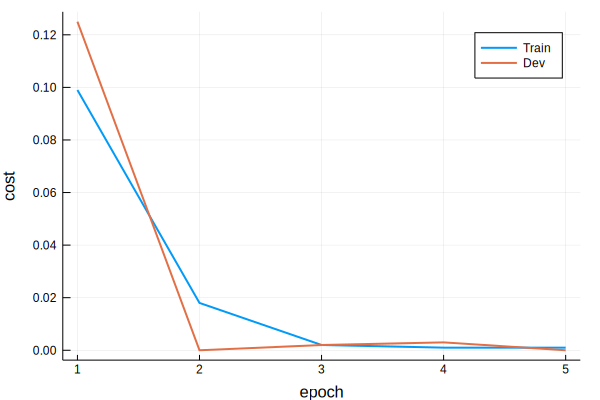

In [831]:
# Plot history
plot_history(history)

In [832]:
# Train accuracy
Yhat = predict(X, parameters);
acc = accuracy(Y, Yhat)

0.9717

In [833]:
# Dev accuracy
Yhat_dev = predict(X_dev, parameters);
# Accuracy
acc_dev = accuracy(Y_dev, Yhat_dev)

0.9644285714285714

### Predict on test data

In [834]:
# Test accuracy
Yhat_tst = predict(X_test, parameters);
# Accuracy
acc_tst = accuracy(Y_test, Yhat_tst)

0.9693333333333334